In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(physical_devices[0], 
   [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])

print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import torch
torch.cuda.empty_cache()


2024-12-17 12:14:47.069351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734412487.082568   68745 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734412487.086313   68745 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 12:14:47.100178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 70599201423984720
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3710910464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 322341774309133867
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1734412489.096815   68745 gpu_device.cc:2022] Created device /device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
from datasets import load_dataset

data_files = {
    "indosum/test.04.jsonl",
}

# Muat dataset
dataset = load_dataset("json", data_files=data_files)
print(dataset)

/home/rakhargo/miniconda3/envs/coba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'],
        num_rows: 3752
    })
})


In [3]:
train_data = dataset['train']
print(train_data[0])

{'category': 'tajuk utama', 'gold_labels': [[True], [False, False, False], [False], [True], [True], [False], [False], [False], [False, False], [False], [False, False, False], [False, False], [False]], 'id': '1504151262-wiranto-yakin-uang-bos-first-travel-bisa-ditemukan', 'paragraphs': [[['Jakarta', ',', 'CNN', 'Indonesia', '-', '-', 'Menteri', 'Koordinator', 'bidang', 'Politik', ',', 'Hukum', ',', 'dan', 'Keamanan', '(', 'Menko', 'Polhukam', ')', 'Wiranto', 'yakin', 'uang', 'jemaah', 'yang', 'dikumpulkan', 'bos', 'First', 'Travel', ',', 'Andika', 'Surachman', 'dan', 'Anniesa', 'Hasibuan', ',', 'bisa', 'ditemukan', '.']], [['"', 'Uang', 'itu', 'kan', 'cuma', 'pindah', 'tempat', ',', 'enggak', 'ada', 'uang', 'menguap', ',', 'itu', 'enggak', 'ada', '.'], ['Enggak', 'ada', 'tiba-tiba', 'uang', 'hilang', 'menguap', ',', 'mesti', 'pindah', 'tempat', '.'], ['Kita', 'cari', 'itu', ',', '"', 'ujar', 'Wiranto', 'di', 'Hotel', 'Arya', 'Duta', ',', 'Jakarta', ',', 'Rabu', '\xa0', '(', '30', '/', '

In [4]:
def join_data(dataset):
    documents = []
    summaries = []
    for item in dataset:
        document = [" ".join(sent) for para in item["paragraphs"] for sent in para]
        summary = " ".join([" ".join(sent) for sent in item["summary"]])
        
        documents.append(document)
        summaries.append(summary)
    
    return documents, summaries

# Memproses data
train_docs, train_summaries = join_data(train_data)

In [5]:
print(train_docs[0])
print(train_summaries[0])
len(train_docs)

['Jakarta , CNN Indonesia - - Menteri Koordinator bidang Politik , Hukum , dan Keamanan ( Menko Polhukam ) Wiranto yakin uang jemaah yang dikumpulkan bos First Travel , Andika Surachman dan Anniesa Hasibuan , bisa ditemukan .', '" Uang itu kan cuma pindah tempat , enggak ada uang menguap , itu enggak ada .', 'Enggak ada tiba-tiba uang hilang menguap , mesti pindah tempat .', 'Kita cari itu , " ujar Wiranto di Hotel Arya Duta , Jakarta , Rabu \xa0 ( 30 / 8 ) .', 'Pernyataan Wiranto itu merujuk tipisnya jumlah dana yang berada di rekening bos First Travel , sementara jemaah yang dana keberangkatan umrahnya ditilap mencapai sekitar Rp 848 miliar .', 'Wiranto mengatakan , uang yang diambil bos First Travel tersebut penting untuk ditemukan karena harus dikembalikan kepada para jemaah yang telah ditipu .', 'Mantan Panglima ABRI itu juga menyampaikan , First Travel tetap menjadi pihak yang harus bertanggung jawab untuk mengembalikan uang para jemaah .', '" Yang gantinya siapa yang merugikan r

3752

In [6]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# test
train_docs, test_docs, train_summaries, test_summaries = train_test_split(
    train_docs, train_summaries, test_size=0.05, random_state=42
)

# val
train_docs, val_docs, train_summaries, val_summaries = train_test_split(
    train_docs, train_summaries, test_size=0.2, random_state=42
)

print(f"Train: {len(train_docs)}")
print(f"Validation: {len(val_docs)}")
print(f"Test: {len(test_docs)}")



Train: 2851
Validation: 713
Test: 188


In [7]:
from datasets import DatasetDict

train_dataset = Dataset.from_dict({"document": train_docs, "summary": train_summaries})
val_dataset = Dataset.from_dict({"document": val_docs, "summary": val_summaries})
test_dataset = Dataset.from_dict({"document": test_docs, "summary": test_summaries})

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary'],
        num_rows: 2851
    })
    validation: Dataset({
        features: ['document', 'summary'],
        num_rows: 713
    })
    test: Dataset({
        features: ['document', 'summary'],
        num_rows: 188
    })
})


In [8]:
from transformers import AutoTokenizer, AutoModel, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

model_name = "Wikidepia/IndoT5-small"

tokenizer = T5Tokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = ["summarize: " + " ".join(doc) for doc in examples["document"]]
    targets = examples["summary"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Tokenisasi target (summary)
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenisasi dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Map: 100%|██████████| 188/188 [00:00<00:00, 720.54 examples/s]


In [9]:
print(tokenized_datasets['train'][0])
print(tokenized_datasets['validation'][0])
print(tokenized_datasets['test'][0])

{'document': ['Jakarta , CNN Indonesia - - MotoGP telah merilis draf kalender musim 2017 , Rabu ( 21 / 9 ) .', 'Tidak ada perubahan jadwal balapan setelah Indonesia dan Thailand gagal menjadi tuan rumah .', 'Dorna Sports selaku pengelola MotoGP , sempat melakukan negosiasi dengan pemerintah Indonesia dan Sirkuit Buriram Thailand untuk menggelar MotoGP mulai 2017 .', 'Namun , Indonesia dan Thailand gagal memenuhi syarat hingga batas waktu yang telah ditentukan .', 'Indonesia gagal menjadi salah satu tuan rumah musim depan karena tidak adanya sirkuit yang memenuhi kriteria .', 'Sedangkan Thailand dikabarkan terbentur kontrak bersama Superbike yang akan berakhir 2017 .', 'Kondisi tersebut membuat MotoGP 2017 akan kembali berlangsung sepanjang 18 seri , sama seperti musim ini .', 'Dikutip dari Autosport , perubahan signifikan hanya terjadi di jeda waktu antar - seri balapan .', 'MotoGP memberi jeda waktu dua pekan di antara balapan GP Argentina dan GP Austin musim depan .', 'Keputusan itu 

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    # output_dir="./indoT5_summarization_results",   # Direktori untuk menyimpan model
    evaluation_strategy="steps",                  # Evaluasi setiap beberapa step
    eval_steps=500,                               # Frekuensi evaluasi
    save_steps=0,                               # Frekuensi menyimpan model
    logging_dir=None,                         # Direktori log
    learning_rate=0.001,                           # Learning rate
    per_device_train_batch_size=4,                # Batch size per device
    per_device_eval_batch_size=4,                 # Batch size untuk evaluasi
    num_train_epochs=5,                           # Jumlah epoch
    weight_decay=0.01,                            # Regularisasi L2
    save_total_limit=2,                           # Simpan hanya 2 checkpoint terbaik
    load_best_model_at_end=True,                  # Load model terbaik berdasarkan evaluasi
    report_to="none",                              # Nonaktifkan logging ke W&B
    gradient_checkpointing=True,
)


/home/rakhargo/miniconda3/envs/coba/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from transformers import Trainer

model = T5ForConditionalGeneration.from_pretrained(model_name)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

# Mulai proses training
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
500,1.728700,0.421764
1000,0.419400,0.394146
1500,0.336600,0.387927
2000,0.266800,0.397217
2500,0.204600,0.406568
3000,0.174800,0.444735
3500,0.147800,0.442413


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Could not locate the best model at ./indoT5_summarization_results/checkpoint-1500/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=3565, training_loss=0.4622146809753161, metrics={'train_runtime': 1156.3316, 'train_samples_per_second': 12.328, 'train_steps_per_second': 3.083, 'total_flos': 2649869144555520.0, 'train_loss': 0.4622146809753161, 'epoch': 5.0})

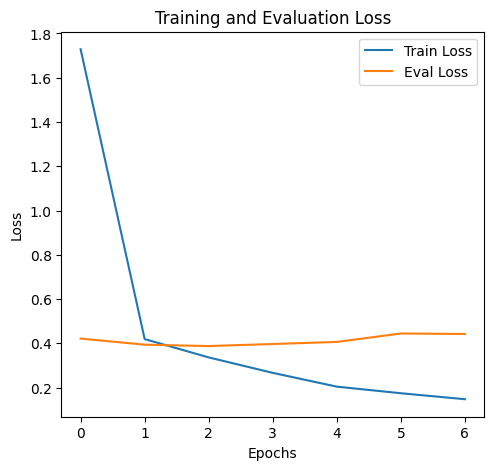

In [12]:
import matplotlib.pyplot as plt
# Mengambil data dari log
train_logs = trainer.state.log_history

# Membuat list untuk loss dan accuracy
train_loss = []
eval_loss = []

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label="Train Loss")
plt.plot(range(len(eval_loss)), eval_loss, label="Eval Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()

# Tampilkan plot
plt.show()


In [14]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from transformers import Trainer

# Menghitung BLEU score
def compute_bleu(predicted, reference):
    reference = [ref.split() for ref in reference]  # Tokenize reference
    predicted = predicted.split()  # Tokenize prediction
    return sentence_bleu(reference, predicted)

# Ambil test dataset
test_dataset = tokenized_datasets["test"]

# Menyiapkan Trainer
trainer = Trainer(model=model)

# small_test_dataset = test_dataset.select(range(150))  # Ambil 100 data pertama
predictions = trainer.predict(test_dataset)

predictions_array = predictions.predictions[0]

predicted_ids = predictions_array.argmax(axis=-1)  # Memilih ID token dengan nilai tertinggi di setiap posisi token

# Mengubah hasil prediksi menjadi list dan mendekode
decoded_preds = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

# Mengambil label dari predictions.label_ids
labels_array = predictions.label_ids
decoded_labels = tokenizer.batch_decode(labels_array, skip_special_tokens=True)

# Menyimpan BLEU scores
bleu_scores = []
num_samples = 5  # Ambil 5 sampel pertama

# Menampilkan beberapa sampel dan BLEU score untuk masing-masing
for i in range(num_samples):
    input_text = test_dataset[i]["document"]
    actual_summary = decoded_labels[i]
    predicted_summary = decoded_preds[i]

    bleu_score = compute_bleu(predicted_summary, [actual_summary])
    bleu_scores.append(bleu_score)

    # Menampilkan sampel
    print(f"Data {i+1}:")
    print(f"Input Asli: {input_text}")
    print(f"Actual Summary: {actual_summary}")
    print(f"Predicted Summary: {predicted_summary}")
    print(f"BLEU Score: {bleu_score}")
    print("-" * 50)

# Menghitung rata-rata BLEU score
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu_score:.4f}")


Data 1:
Input Asli: ['Jakarta , CNN Indonesia - - Penyelidik Amerika Serikat dilaporkan sudah bertemu dengan Christopher Steele , mantan mata-mata Inggris yang membocorkan isu hubungan antara tim kampanye Donald Trump dan Rusia pada masa pemilihan umum 2016 .', 'Informasi mengenai pertemuan ini dihimpun oleh CNN dari dua sumber yang dekat dengan penyelidikan .', 'CNN melaporkan , pertemuan antara penyelidik dari dewan khusus pimpinan mantan Kepala FBI , Robert Mueller , bertemu dengan Steele pada musim panas lalu .', '" CNN mengetahui bahwa FBI dan komunitas intelijen AS menanggapi bocoran Steele lebih serius ketimbang badan-badan lain yang mengetahuinya , " demikian bunyi laporan CNN , Kamis ( 5 / 10 ) .', 'Nama Steele menjadi perhatian publik setelah merilis berkas penelitian politik setebal 35 halaman yang menguak kemungkinan intervensi Rusia untuk memenangkan Trump dalam pemilu lalu .', 'Berkas itu mencakup klaim bahwa Rusia memiliki video prostitusi yang direkam saat Trump mengunj